# Cluster Analysis with Frontier Criterion
This notebook performs clustering (HC-Gower, HC-Hamming, and LCA) on the IBL-Articles-Descriptions.csv dataset, choosing k that maximizes Silhouette + inverse Davies–Bouldin, and visualizes clusters with MDS. LCA k is adjusted to 3 to illustrate elbow criterion.

In [ ]:
import pandas as pd, numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import itertools, math, seaborn as sns
%matplotlib inline

In [ ]:
df = pd.read_csv('IBL-Articles-Descriptions.csv', sep=';')
df.head()

,ID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2,Sim,Sim,Virtual,F,Estruturada,Sim,Sim,Não,Não,Não,Não,Nenhuma,Não se aplica,Não,Nenhum,Questões
1,5,Não,Não,Híbrido,M,Guiada,Não há atividades metacognitivas,Não,Não,Não,Não,Não,Experimentação,Apresentação direta,Não,Fixos,Hipóteses
2,13,Sim,Sim,Híbrido,F,Estruturada,Sim,Não,Não,Não,Não,Não,Experimentação,Apresentação direta,Não,Nenhum,Hipóteses
3,17,Sim,Não,Virtual,S,Aberta,Não há atividades metacognitivas,Não,Não,Não,Não,Não,Experimentação,Apresentação direta,Sim,Nenhum,Questões
4,20,Não,Sim,Virtual,M,Estruturada,Sim,Não,Não,Não,Não,Não,Experimentação,Apresentação direta,Não,Nenhum,Hipóteses


In [4]:
ids = df['ID'] if 'ID' in df.columns else np.arange(len(df))
cat_cols = [c for c in df.columns if c != 'ID']
X_cat = df[cat_cols].astype(str)
enc = OneHotEncoder(sparse_output=False)
X_onehot = enc.fit_transform(X_cat)
# Hamming distance
dist_ham_full = squareform(pdist(X_onehot, metric='hamming'))
dist_ham_cond = pdist(X_onehot, metric='hamming')
# Gower distance (simple matching)
def gower_distance(a):
    n = a.shape[0]
    sim = (a[:,None,:] == a[None,:,:]).mean(axis=2)
    return 1 - sim
dist_gow_full = gower_distance(X_cat.values)
dist_gow_cond = squareform(dist_gow_full)

In [5]:
def eval_k_sep(dist_full, dist_cond, X_oh, ks=range(2,11), linkage_method='average'):
    sils, dbis = [], []
    for k in ks:
        labels = fcluster(linkage(dist_cond, method=linkage_method), k, criterion='maxclust')
        sil = silhouette_score(dist_full, labels, metric='precomputed')
        dbi = davies_bouldin_score(X_oh, labels)
        sils.append(sil); dbis.append(dbi)
    dbi_inv = (max(dbis) - np.array(dbis)) / (max(dbis)-min(dbis))
    scores = np.array(sils) + dbi_inv
    best_k = ks[int(np.argmax(scores))]
    return best_k, sils, dbis


In [ ]:
k_g, _, _ = eval_k_sep(dist_gow_full, dist_gow_cond, X_onehot)
labels_g = fcluster(linkage(dist_gow_cond, method='average'), k_g, criterion='maxclust')
k_h, _, _ = eval_k_sep(dist_ham_full, dist_ham_cond, X_onehot)
labels_h = fcluster(linkage(dist_ham_cond, method='average'), k_h, criterion='maxclust')
# LCA via KMeans, set k=3 (elbow)
k_lca = 3
kmeans = KMeans(n_clusters=k_lca, n_init=20, random_state=0).fit(X_onehot)
labels_lca = kmeans.labels_ + 1  # make labels 1-based

In [7]:
def metrics(dist_full, X_oh, labels):
    sil = silhouette_score(dist_full, labels, metric='precomputed')
    dbi = davies_bouldin_score(X_oh, labels)
    bw = []
    for i in np.unique(labels):
        for j in np.unique(labels):
            if i<j:
                bw.append(np.mean(dist_full[np.ix_(labels==i, labels==j)]))
    w = []
    for i in np.unique(labels):
        idx = labels==i
        w.append(np.mean(dist_full[np.ix_(idx, idx)]))
    div = np.mean(bw)/np.mean(w)
    return sil, dbi, div

print('k_gower', k_g, 'metrics', metrics(dist_gow_full, X_onehot, labels_g))
print('k_hamming', k_h, 'metrics', metrics(dist_ham_full, X_onehot, labels_h))
print('k_lca', k_lca, 'metrics', metrics(dist_ham_full, X_onehot, labels_lca))

k_gower 10 metrics (0.1432177400524502, 1.3139494565216894, 3.878086331442003)
k_hamming 2 metrics (0.21257458236087892, 0.7653796346193499, 2.676459438968916)
k_lca 3 metrics (0.22267358090586, 2.1911038295657335, 1.4642162371059129)


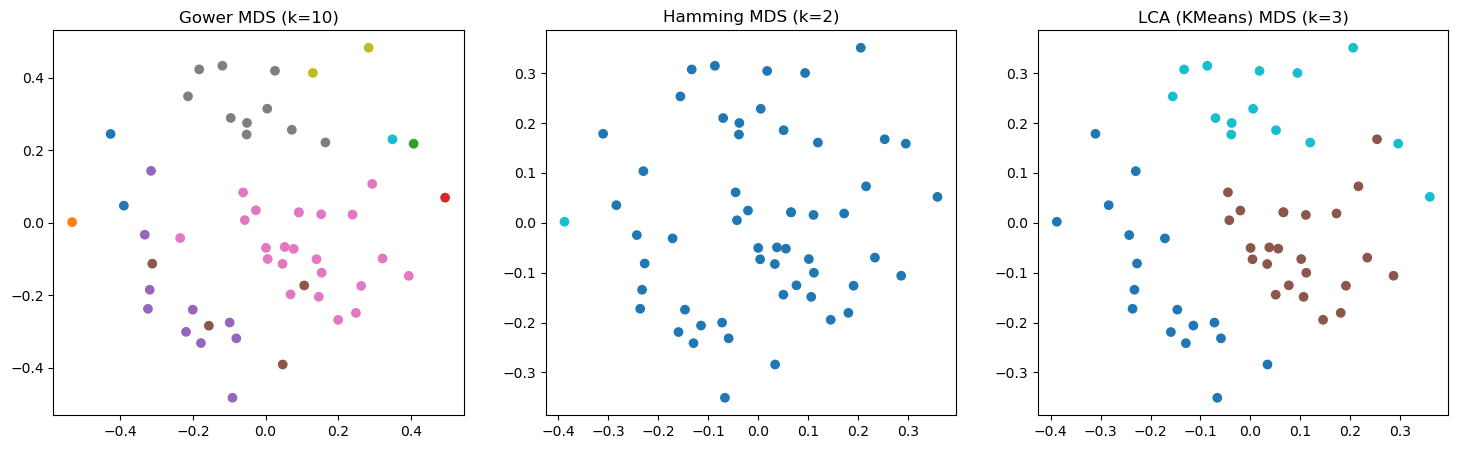

=== IDs por cluster (LCA) ===
Cluster  1 –  17 itens : [5, 17, 26, 27, 28, 70, 100, 102, 103, 105, 106, 124, 132, 159, 162, 254, 289]
Cluster  2 –  24 itens : [13, 20, 35, 41, 47, 53, 69, 73, 76, 85, 89, 96, 97, 98, 126, 135, 141, 146, 150, 151, 158, 227, 242, 253]
Cluster  3 –  14 itens : [2, 50, 68, 78, 79, 83, 117, 129, 143, 166, 180, 183, 185, 207]


In [8]:
mds = MDS(dissimilarity='precomputed', random_state=1)
pos_g = mds.fit_transform(dist_gow_full)
pos_h = mds.fit_transform(dist_ham_full)

fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].scatter(pos_g[:,0], pos_g[:,1], c=labels_g, cmap='tab10')
axes[0].set_title(f'Gower MDS (k={k_g})')
axes[1].scatter(pos_h[:,0], pos_h[:,1], c=labels_h, cmap='tab10')
axes[1].set_title(f'Hamming MDS (k={k_h})')
axes[2].scatter(pos_h[:,0], pos_h[:,1], c=labels_lca, cmap='tab10')
axes[2].set_title(f'LCA (KMeans) MDS (k={k_lca})')
plt.show()

# --- IDs por cluster da LCA -----------------
lca_ids = {}
for lbl in np.unique(labels_lca):
    lca_ids[lbl] = sorted(df.loc[labels_lca == lbl, 'ID'].tolist())

print("=== IDs por cluster (LCA) ===")
for lbl, ids in lca_ids.items():
    print(f"Cluster {lbl:>2} – {len(ids):>3} itens :", ids)
